# Spotify Song Popularity Analysis - Clean Dataset

Using the cleaned dataset where:
- Duplicates have been removed
- '0' rated songs filtered out

This gives us a more accurate picture of song popularity patterns.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Configure plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True

Dataset Shape: (21199, 25)

Popularity Statistics:
count    21199.000000
mean        45.379829
std         20.542204
min          0.000000
25%         32.000000
50%         47.000000
75%         61.000000
max        100.000000
Name: track_popularity, dtype: float64


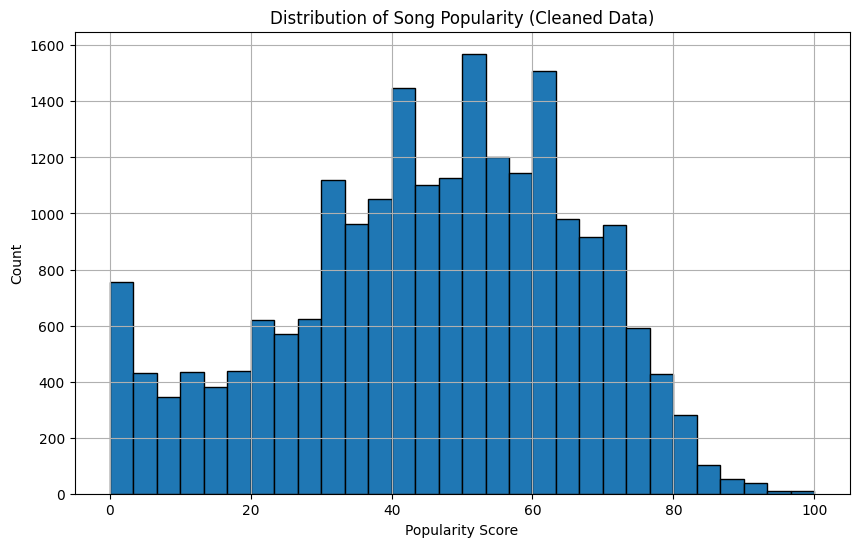

In [3]:
# Load cleaned data from Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1ae96nZRL_kJWb_EEv2avxMOgGClvyc77SpY-VBqVGiY/edit#gid=1052928543"
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

# Read the data
df = pd.read_csv(csv_export_url)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nPopularity Statistics:")
print(df['track_popularity'].describe())

# Visualize popularity distribution
plt.figure(figsize=(10, 6))
plt.hist(df['track_popularity'], bins=30, edgecolor='black')
plt.title('Distribution of Song Popularity (Cleaned Data)')
plt.xlabel('Popularity Score')
plt.ylabel('Count')
plt.show()

## Feature Engineering and Preprocessing

Using the cleaned data, we'll:
1. Create popularity categories based on the new distribution
2. Engineer meaningful feature combinations
3. Apply proper scaling and encoding


Popularity Category Distribution:
popularity_category
Medium    7502
High      7016
Low       6681
Name: count, dtype: int64


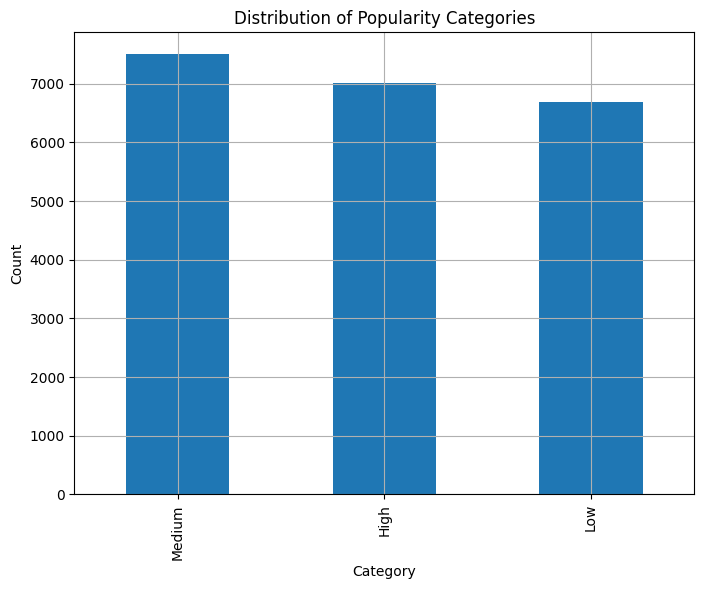

In [4]:
# Define features
numeric_features = [
    'danceability', 'energy', 'key', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'duration_ms'
]

categorical_features = ['playlist_genre', 'mode']

# Create engineered features
df['energy_danceability'] = df['energy'] * df['danceability']
df['loudness_scaled'] = (df['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
df['tempo_scaled'] = df['tempo'] / df['tempo'].max()

# Add engineered features to numeric features list
numeric_features += ['energy_danceability', 'loudness_scaled', 'tempo_scaled']

# Create popularity categories based on quartiles
popularity_quartiles = df['track_popularity'].quantile([0.33, 0.67])
def categorize_popularity(x):
    if x >= popularity_quartiles[0.67]:
        return 'High'
    elif x >= popularity_quartiles[0.33]:
        return 'Medium'
    else:
        return 'Low'

df['popularity_category'] = df['track_popularity'].apply(categorize_popularity)

# Display category distribution
print("\nPopularity Category Distribution:")
print(df['popularity_category'].value_counts())

plt.figure(figsize=(8, 6))
df['popularity_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Popularity Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

## Model Comparison with Proper Preprocessing

We'll compare multiple scikit-learn models:
1. Random Forest
2. Gradient Boosting
3. Neural Network (MLP)
4. Support Vector Machine (SVM)
5. K-Nearest Neighbors (KNN)


Training Random Forest...
Random Forest Results:
Accuracy: 0.4483

Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.55      0.52      1403
         Low       0.45      0.39      0.41      1336
      Medium       0.41      0.41      0.41      1501

    accuracy                           0.45      4240
   macro avg       0.45      0.45      0.45      4240
weighted avg       0.45      0.45      0.45      4240

--------------------------------------------------

Training Gradient Boosting...
Gradient Boosting Results:
Accuracy: 0.4604

Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.59      0.54      1403
         Low       0.46      0.40      0.43      1336
      Medium       0.42      0.40      0.41      1501

    accuracy                           0.46      4240
   macro avg       0.46      0.46      0.46      4240
weighted avg       0.46      0.46      0.46      424

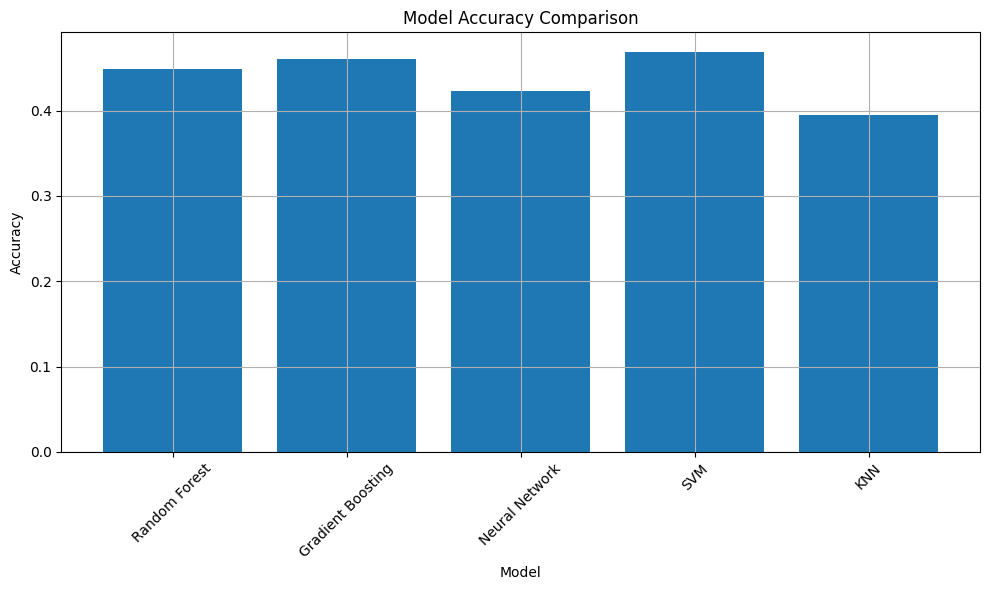


Best Model: SVM with accuracy: 0.4684


In [6]:
# Prepare data
X = df[numeric_features + categorical_features]
y = df['popularity_category']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Store results
    results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print results
    print(f"{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(results[name]['report'])
    print("-" * 50)

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
accuracies = [results[model]['accuracy'] for model in results]
plt.bar(results.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest Model: {best_model[0]} with accuracy: {best_model[1]['accuracy']:.4f}")

## Feature Analysis for Best Model


Note: SVM does not provide feature importance scores.


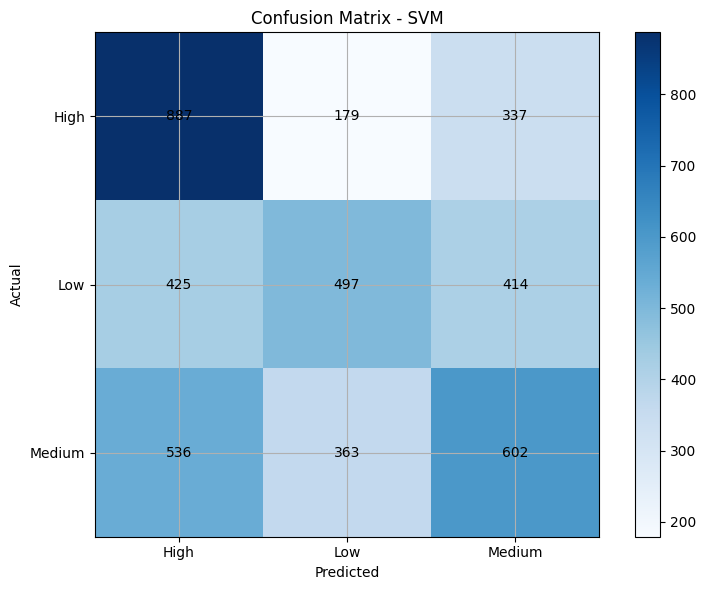

In [8]:
# Analyze feature importance for tree-based models
if hasattr(best_model[1]['pipeline'].named_steps['classifier'], 'feature_importances_'):
    # Get feature names
    feature_names = (numeric_features + 
                    [f"{feat}_{val}" for feat, vals in 
                     best_model[1]['pipeline'].named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features)
                     for val in vals])
    
    # Get importance
    importance = best_model[1]['pipeline'].named_steps['classifier'].feature_importances_
    
    # Create DataFrame
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(15), feature_importance['importance'][:15])
    plt.xticks(range(15), feature_importance['feature'][:15], rotation=45, ha='right')
    plt.title(f'Top 15 Features for {best_model[0]}')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
else:
    print(f"\nNote: {best_model[0]} does not provide feature importance scores.")

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
plt.imshow(best_model[1]['confusion_matrix'], cmap='Blues')
plt.colorbar()
plt.xticks(range(3), ['High', 'Low', 'Medium'])
plt.yticks(range(3), ['High', 'Low', 'Medium'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model[0]}')

# Add text annotations
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(best_model[1]['confusion_matrix'][i, j]),
                 ha='center', va='center')
plt.tight_layout()
plt.show()